In [2]:
from google.cloud import vision
import io
import glob
import os
import os.path
import cv2
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image
###### before running, please run export GOOGLE_APPLICATION_CREDENTIALS='/path/to/your/client_secret.json'
#export GOOGLE_APPLICATION_CREDENTIALS='/c/Users/poorv/Downloads/ocr_scripts/keys/direct-outlook-270501-c05c2d97d1c6.json'
#echo $GOOGLE_APPLICATION_CREDENTIALS 
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 
#"C:/Users/poorv/Downloads/ocr_scripts/keys/direct-outlook-270501-c05c2d97d1c6.json"

[(781, 1603, 44, 16), (1101, 1588, 26, 29), (823, 1585, 148, 33), (733, 1498, 48, 7), (698, 1496, 19, 11), (653, 1496, 26, 11), (550, 1496, 90, 11), (375, 1496, 160, 11), (1125, 1413, 26, 12), (928, 1403, 33, 8), (1046, 1392, 65, 30), (931, 1259, 16, 14), (955, 1254, 50, 20), (1143, 1252, 45, 26), (883, 1248, 42, 24), (1044, 1241, 17, 8), (1078, 1238, 53, 31), (1036, 1158, 106, 37), (1132, 1089, 18, 21), (955, 1010, 66, 13), (1031, 1009, 21, 18), (1071, 1000, 90, 39), (887, 936, 26, 16), (922, 927, 33, 27), (860, 927, 19, 8), (788, 927, 55, 20), (1110, 926, 60, 39), (1019, 926, 86, 34), (985, 926, 30, 12), (292, 856, 52, 13), (364, 850, 56, 17), (426, 847, 49, 19), (1148, 844, 11, 9), (476, 844, 43, 21), (687, 840, 172, 18), (534, 838, 102, 26), (964, 824, 25, 23), (894, 823, 61, 17), (992, 820, 22, 30), (1017, 816, 73, 34), (961, 752, 77, 21), (1067, 746, 22, 13), (1162, 745, 30, 28), (845, 742, 117, 18), (1079, 735, 97, 38), (367, 696, 21, 7), (556, 692, 19, 8), (403, 692, 72, 11), (

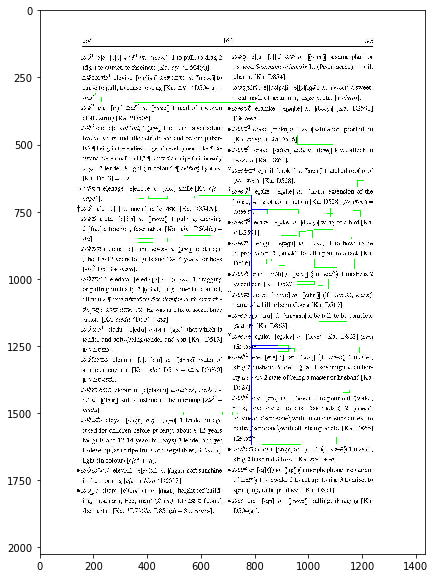

In [50]:
pg188 = "jpgs/output-190-to-190.jpg"
os.path.isfile(pg188)
tc = cv2.imread(pg188) 
# sa(tc)

im = tc.copy()
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(im_gray,127,255,cv2.THRESH_BINARY_INV)
# sa(thresh)

edges = cv2.Canny(im_gray,50,150,apertureSize = 3)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 200  # minimum number of pixels making up a line
max_line_gap = 500  # maximum gap in pixels between connectable line segments
# line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(thresh,(x1,y1),(x2,y2),(255,0,0),15)
# minLineLength = 1
# maxLineGap = 500
# # lines=np.empty()
# # lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
# # print(lines)
# # lines = cv2.HoughLinesP(edges,1,np.pi/180,100,lines=np.array([]), minLineLength=1,maxLineGap=500)
# # print(lines)
# # lines = cv2.HoughLinesP(edges,rho = 1,theta = 1*np.pi/180,lines = 100, threshold = 100, minLineLength = 100,maxLineGap = 100)
# # print(lines)
# for line in lines:
#     for x1,y1,x2,y2 in line:
#         cv2.line(thresh,(x1,y1),(x2,y2),(0),5)
# # sa(thresh)

kernel = np.ones((3,3),np.uint8)
thresh = cv2.erode(thresh, np.ones((1, 1) ,np.uint8), iterations=5)
# thresh = cv2.dilate(erosion,kernel,iterations = 10)
# struct = cv2.getStructuringElement(cv2.MORPH_RECT, (100,100))
# thresh = cv2.dilate(thresh, struct, anchor=(-1, -1), iterations=20)

contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
minArea=10000 #nothing 
for cnt in contours:
    area=cv2.contourArea(cnt)
    if(area>minArea):
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(im,[box],0,(0,0,255),2)
        
        
text_boxes = find_text_boxes(thresh)
# print(text_boxes)
cells = find_table_in_boxes(text_boxes)
# print(cells)
hor_lines, ver_lines = build_lines(cells)


imt = tc.copy()

for box in text_boxes:
    (x, y, w, h) = box
    cv2.rectangle(imt, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(imt, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(imt, (x1, y1), (x2, y2), (0, 0, 255), 1)

        
fig2 = plt.figure(figsize = (15,10)) # create a 5 x 5 figure 
# # plt.subplot(131)
# # plt.imshow(edges,cmap = 'gray')
# # plt.subplot(132)
# # plt.imshow(thresh,cmap = 'gray')
# # plt.subplot(133)
plt.subplot(111)
plt.imshow(imt,cmap = 'gray')
plt.show()


# OCR

In [ ]:
def dtlh(path, lh):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(
    image=image,
    image_context={"language_hints": lh},  # Bengali
    )
    texts = response.text_annotations
    print(texts[0].description)
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
dtlh(pg188, ["kn"])

In [45]:
import os
import cv2
# import imutils

# This only works if there's only one table on a page
# Important parameters:
#  - morph_size
#  - min_text_height_limit
#  - max_text_height_limit
#  - cell_threshold
#  - min_columns

def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes


def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells